In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [16]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Dataset 
a) Download the first 6 classes (class 0 to 5) of "German Traffic Sign Recognition Benchmark" dataset from Kaggle
https://www.kaggle.com/datasets/aakcodebreaker/german-traffic-sign-recognition-benchmark . Copy both training and test datasets.

In [17]:
# Dataset downloaded and organized
# The dataset should be in the following structure:
# ./data/Train/0/, ./data/Train/1/, ..., ./data/Train/5/
# ./data/Test/0/, ./data/Test/1/, ..., ./data/Test/5/

import os
if os.path.exists('./data/Train') and os.path.exists('./data/Test'):
    print("✓ Dataset directories found!")
    print(f"  Train: ./data/Train")
    print(f"  Test: ./data/Test")
else:
    print("⚠ Dataset not found. Please ensure the data is organized in ./data/Train and ./data/Test")

✓ Dataset directories found!
  Train: ./data/Train
  Test: ./data/Test


b) Calculate the mean and standard deviation of the training images.

In [18]:
# Calculate mean and standard deviation of training images
import os
from PIL import Image

def calculate_mean_std(data_dir, classes):
    """
    Calculate mean and std deviation for the training dataset
    data_dir: path to the Train folder
    classes: list of class folders to include (0-5)
    """
    pixel_sum = np.zeros(3)
    pixel_sq_sum = np.zeros(3)
    pixel_count = 0
    
    for class_id in classes:
        class_path = os.path.join(data_dir, str(class_id))
        if not os.path.exists(class_path):
            continue
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                
                pixel_sum += img_array.sum(axis=(0, 1))
                pixel_sq_sum += (img_array ** 2).sum(axis=(0, 1))
                pixel_count += img_array.shape[0] * img_array.shape[1]
            except:
                continue
    
    mean = pixel_sum / pixel_count
    std_dev = np.sqrt(pixel_sq_sum / pixel_count - mean ** 2)
    
    return mean, std_dev

# Assuming the dataset is in a folder structure like:
# ./data/Train/0/, ./data/Train/1/, ..., ./data/Train/5/
# Modify this path according to where you extract the dataset
train_data_path = './data/Train'
classes = [0, 1, 2, 3, 4, 5]

# Check if data directory exists
if os.path.exists(train_data_path):
    mean, std_dev = calculate_mean_std(train_data_path, classes)
    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std_dev}")
else:
    print("Dataset not found. Please download and extract the dataset to './data/'")
    print("Using ImageNet statistics as placeholder:")
    # Using ImageNet statistics as fallback
    mean = np.array([0.485, 0.456, 0.406])
    std_dev = np.array([0.229, 0.224, 0.225])

Mean: [0.38826751 0.34297478 0.34412396]
Standard Deviation: [0.30209747 0.29188096 0.29758781]


c) Implement the custom dataset class for training and test.  Don't use Pytorch ``ImageFolder``. 
For training, do the following transforms and data augmentation: 
 - resize the images to 64 by 64.
 - Horizontal flip with a probabilty of 0.25
 - Vertical flip with a probabilty of 0.25
 - random rotation between 0 and 10 degrees.
 - Convert ``dtype`` to ``float32`` and scale between $0$ and $1$
 - then Normalize with the mean and std. dev. obtained in step b.
 
For testing, resize to 64 by 64, convert ``dtype`` to ``float32`` and scale between $0$ and $1$ and normalize.

(i) In the init method, store the path to the images and labels. You can use any data structure of your choice, e.g., list/nested list, dictionary, or pandas dataframe.

(ii) in the getitem method, use the path stored at position ``idx`` to load the image. Return image and its label. 

In [19]:
class TrafficSignDataset(Dataset):
    def __init__(self, root_dir, training=True, transform=None, mean=None, std_dev=None):
        """
        Custom Dataset for German Traffic Sign Recognition
        root_dir: path to Train or Test folder
        training: True for training mode (with augmentation), False for test mode
        transform: optional additional transforms
        mean, std_dev: normalization parameters
        """
        self.root_dir = root_dir
        self.training = training
        self.transform = transform
        self.mean = mean if mean is not None else np.array([0.485, 0.456, 0.406])
        self.std_dev = std_dev if std_dev is not None else np.array([0.229, 0.224, 0.225])
        
        # Store image paths and labels
        self.image_paths = []
        self.labels = []
        
        # Load data for classes 0-5
        for class_id in range(6):
            class_path = os.path.join(root_dir, str(class_id))
            if not os.path.exists(class_path):
                continue
            
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(class_id)
        
        # Define transforms based on training/test mode
        if self.training:
            # Training transforms with augmentation
            self.transforms_list = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.RandomHorizontalFlip(p=0.25),
                transforms.RandomVerticalFlip(p=0.25),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor(),  # Converts to float32 and scales to [0, 1]
                transforms.Normalize(mean=self.mean, std=self.std_dev)
            ])
        else:
            # Test transforms without augmentation
            self.transforms_list = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),  # Converts to float32 and scales to [0, 1]
                transforms.Normalize(mean=self.mean, std=self.std_dev)
            ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        image = self.transforms_list(image)
        
        # Get label
        label = self.labels[idx]
        
        return image, label

d) Instantiate training and test datasets.

In [20]:
# Instantiate training and test datasets
train_data_path = './data/Train'
test_data_path = './data/Test'

# Create full training dataset
full_train_dataset = TrafficSignDataset(
    root_dir=train_data_path,
    training=True,
    mean=mean,
    std_dev=std_dev
)

# Create test dataset
test_dataset = TrafficSignDataset(
    root_dir=test_data_path,
    training=False,
    mean=mean,
    std_dev=std_dev
)

print(f"Full training dataset size: {len(full_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Full training dataset size: 9930
Test dataset size: 3270


e) Partition the training dataset further into training and validation. 20% of training images are validation. Configure the dataloaders with batch size of 16.

In [21]:
# Partition training dataset into train and validation (80/20 split)
from torch.utils.data import random_split

# Calculate split sizes
total_size = len(full_train_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 7944
Validation set size: 1986
Test set size: 3270


In [22]:
# Configure dataloaders with batch size of 16
batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Set to 0 to avoid multiprocessing issues in Jupyter
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0  # Set to 0 to avoid multiprocessing issues in Jupyter
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0  # Set to 0 to avoid multiprocessing issues in Jupyter
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 497
Number of validation batches: 125
Number of test batches: 205


e) Visualize two random training images.

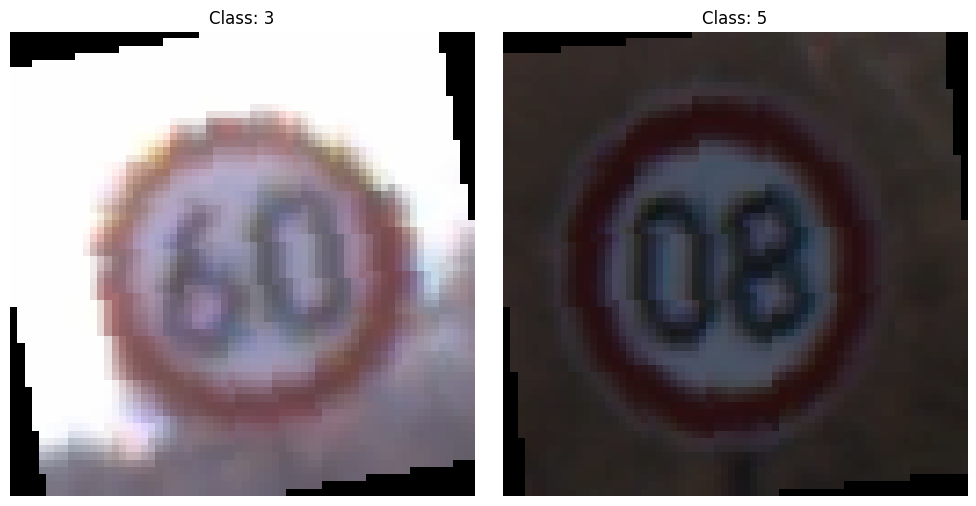

In [23]:
# Visualize two random training images
import random

# Get two random indices
indices = random.sample(range(len(train_dataset)), 2)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx, ax in zip(indices, axes):
    # Get image and label
    image, label = train_dataset[idx]
    
    # Denormalize image for visualization
    image_np = image.numpy().transpose(1, 2, 0)
    image_np = image_np * std_dev + mean
    image_np = np.clip(image_np, 0, 1)
    
    # Display
    ax.imshow(image_np)
    ax.set_title(f'Class: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Q1. CNN
a) Build a NN network specified in the figure below and initialize the parameters. 

The network consists of:
1. Convolution layer: 16 3x3 filters with stride=1. Set the padding such that the output size is half of the input. Convolution is followed by BatchNorm and ReLu Activation fuction.
1. Maxpool with 2x2 filters and stride = 2
2. Convolution layer: 16 3x3 filters with stride=2. Set the padding such that the output size is half of the input. Convolution is followed by BatchNorm and ReLu Activation fuction.
1. Convolution layer: 32 3x3 filters. Convolution is followed by BatchNorm and ReLu Activation fuction.
2. Convolution layer: 64 3x3 filters with stride=2. Set the padding such that the output size is half of the input. Convolution is followed by BatchNorm and ReLu Activation fuction.
3. A fully connected output layer.


Note: select padding of the convolution input such that output height and width are an integer division of input size. 


In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Layer 1: Conv (16, 3x3, stride=1, padding=1) + BatchNorm + ReLU
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        
        # MaxPool (2x2, stride=2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 2: Conv (16, 3x3, stride=2, padding=1) + BatchNorm + ReLU
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        
        # Layer 3: Conv (32, 3x3, stride=1, padding=1) + BatchNorm + ReLU
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        
        # Layer 4: Conv (64, 3x3, stride=2, padding=1) + BatchNorm + ReLU
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        
        # Fully connected output layer
        # After all convolutions: 64x64 -> 64x64 -> 32x32 -> 16x16 -> 16x16 -> 8x8
        self.fc = nn.Linear(64 * 8 * 8, 6)  # 6 classes (0-5)
        
    def forward(self, input):
        # Layer 1: Conv + BN + ReLU
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu1(x)
        
        # MaxPool
        x = self.maxpool(x)
        
        # Layer 2: Conv + BN + ReLU
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        # Layer 3: Conv + BN + ReLU
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        # Layer 4: Conv + BN + ReLU
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        output = self.fc(x)
        
        return output

b) Create a model

In [25]:
cnn_model = CNN()

# if you use GPU, uncomment the floolowing line
# cnn_model = cnn_model.cuda()

c) Do forward propagation for a minibatch and verify that the output shape equals the number of samples in a minibatch by the number of classes.

In [26]:
data,labels = next(iter(train_loader))

output = cnn_model(data)

print(output.shape)

torch.Size([16, 6])


d) Set up the loss and optimizer. 8$. 

In [27]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Hyperparameters (will be set after grid search)
# These are placeholder values - actual values will be determined by grid search
lr = 0.01
momentum = 0.9
weight_decay = 1e-4
epochs = 50

# Optimizer (will be properly configured after hyperparameter tuning)
# optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

## Q2. Hyperparamter tuning

a) Do grid search to find a good combination of the optimizer hyperparamters. Use 
1. lr=1e-3, 1e-2, 1e-1, 1e-0, 10
1. momentum = 0.85, 0.9, 0.95, 0.99
2. weight decay = 0, 1e-4, 1e-2

You need to use nested loop. Run each experiment for two epochs. 


In [28]:
# Hyperparameter grid search
import copy
from tqdm import tqdm

# Define hyperparameter grid
learning_rates = [1e-3, 1e-2, 1e-1, 1.0, 10.0]
momentums = [0.85, 0.9, 0.95, 0.99]
weight_decays = [0, 1e-4, 1e-2]

# Store results
grid_search_results = []
grid_search_losses = {}

print("Starting Grid Search...")
print(f"Total combinations: {len(learning_rates) * len(momentums) * len(weight_decays)}")

# Grid search with nested loops
for lr_val in learning_rates:
    for momentum_val in momentums:
        for wd_val in weight_decays:
            print(f"\nTesting: lr={lr_val}, momentum={momentum_val}, weight_decay={wd_val}")
            
            # Create a fresh model for each configuration
            model = CNN()
            # Uncomment if using GPU
            # model = model.cuda()
            
            # Setup optimizer with current hyperparameters
            optimizer = optim.SGD(model.parameters(), lr=lr_val, momentum=momentum_val, weight_decay=wd_val)
            
            # Train for 2 epochs
            epoch_losses = []
            for epoch in range(2):
                model.train()
                running_loss = 0.0
                num_batches = 0
                
                for batch in train_loader:
                    optimizer.zero_grad()
                    data, target_labels = batch
                    # Uncomment if using GPU
                    # data, target_labels = data.cuda(), target_labels.cuda()
                    
                    # Forward pass
                    prediction = model(data)
                    loss = loss_fn(prediction, target_labels)
                    
                    # Backward pass
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    num_batches += 1
                
                avg_loss = running_loss / num_batches
                epoch_losses.append(avg_loss)
                print(f"  Epoch {epoch+1}/2, Loss: {avg_loss:.4f}")
            
            # Store results
            config_key = f"lr={lr_val}_m={momentum_val}_wd={wd_val}"
            grid_search_losses[config_key] = epoch_losses
            grid_search_results.append({
                'lr': lr_val,
                'momentum': momentum_val,
                'weight_decay': wd_val,
                'final_loss': epoch_losses[-1],
                'losses': epoch_losses
            })

# Find best configuration
best_config = min(grid_search_results, key=lambda x: x['final_loss'])
print("\n" + "="*60)
print("Best configuration found:")
print(f"  Learning rate: {best_config['lr']}")
print(f"  Momentum: {best_config['momentum']}")
print(f"  Weight decay: {best_config['weight_decay']}")
print(f"  Final loss: {best_config['final_loss']:.4f}")
print("="*60)

Starting Grid Search...
Total combinations: 60

Testing: lr=0.001, momentum=0.85, weight_decay=0
  Epoch 1/2, Loss: 1.2479
  Epoch 2/2, Loss: 0.7242

Testing: lr=0.001, momentum=0.85, weight_decay=0.0001
  Epoch 1/2, Loss: 1.1909
  Epoch 2/2, Loss: 0.6521

Testing: lr=0.001, momentum=0.85, weight_decay=0.01
  Epoch 1/2, Loss: 1.1362
  Epoch 2/2, Loss: 0.6420

Testing: lr=0.001, momentum=0.9, weight_decay=0
  Epoch 1/2, Loss: 1.0904
  Epoch 2/2, Loss: 0.5294

Testing: lr=0.001, momentum=0.9, weight_decay=0.0001
  Epoch 1/2, Loss: 1.1945
  Epoch 2/2, Loss: 0.6550

Testing: lr=0.001, momentum=0.9, weight_decay=0.01
  Epoch 1/2, Loss: 1.1092
  Epoch 2/2, Loss: 0.6014

Testing: lr=0.001, momentum=0.95, weight_decay=0
  Epoch 1/2, Loss: 1.1866
  Epoch 2/2, Loss: 0.5813

Testing: lr=0.001, momentum=0.95, weight_decay=0.0001
  Epoch 1/2, Loss: 1.1992
  Epoch 2/2, Loss: 0.5570

Testing: lr=0.001, momentum=0.95, weight_decay=0.01
  Epoch 1/2, Loss: 1.1522
  Epoch 2/2, Loss: 0.5310

Testing: lr=0

b) Plot the training loss. Label each line with corresponding parameters (lr, momentum, and weight decay).  Pick the set of parameters that yields the best loss. 

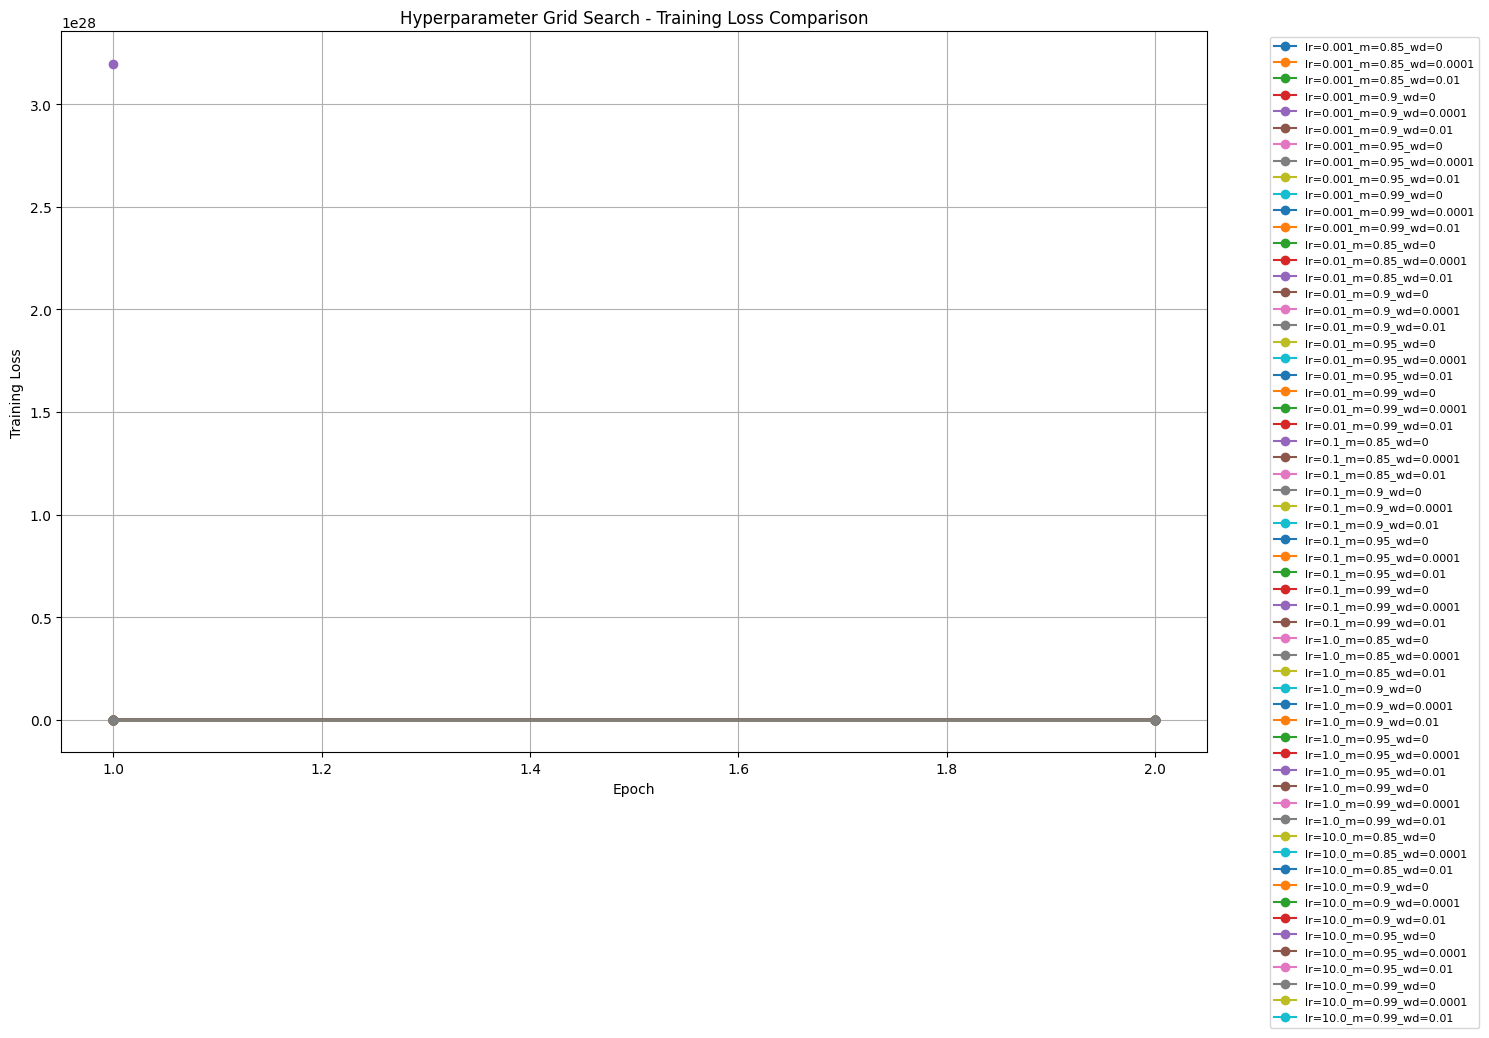


Top 5 configurations by final loss:
1. lr=0.001, momentum=0.9, weight_decay=0, final_loss=0.5294
2. lr=0.001, momentum=0.95, weight_decay=0.01, final_loss=0.5310
3. lr=0.001, momentum=0.95, weight_decay=0.0001, final_loss=0.5570
4. lr=0.001, momentum=0.95, weight_decay=0, final_loss=0.5813
5. lr=0.01, momentum=0.85, weight_decay=0.0001, final_loss=0.5835


In [29]:
# Plot training loss for all hyperparameter combinations
plt.figure(figsize=(15, 10))

for config_key, losses in grid_search_losses.items():
    plt.plot([1, 2], losses, marker='o', label=config_key)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Hyperparameter Grid Search - Training Loss Comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print top 5 configurations
print("\nTop 5 configurations by final loss:")
sorted_results = sorted(grid_search_results, key=lambda x: x['final_loss'])
for i, config in enumerate(sorted_results[:5]):
    print(f"{i+1}. lr={config['lr']}, momentum={config['momentum']}, "
          f"weight_decay={config['weight_decay']}, final_loss={config['final_loss']:.4f}")

## Q3. Training and Evaluation

a) Use the hyperparamters selected in the previous stage to train the model for 50 epochs. Track validation accuracy and save the model whenever validation accuracy is higher. Follow the template and instructions below.

In [30]:
# Create a new model with best hyperparameters
final_cnn_model = CNN()
# Uncomment if using GPU
# final_cnn_model = final_cnn_model.cuda()

# Setup optimizer with best hyperparameters from grid search
best_lr = best_config['lr']
best_momentum = best_config['momentum']
best_weight_decay = best_config['weight_decay']

optimizer = optim.SGD(final_cnn_model.parameters(), lr=best_lr, momentum=best_momentum, weight_decay=best_weight_decay)

print(f"Training with: lr={best_lr}, momentum={best_momentum}, weight_decay={best_weight_decay}")

# Training tracking
training_avg_loss = []
val_avg_loss = []
best_val_acc = 0.0
train_acc = []
val_acc = []

epochs = 50

for epoch in range(epochs):
    # Training
    final_cnn_model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        
        # Unpack batch
        data, target_labels = batch
        # Uncomment if using GPU
        # data, target_labels = data.cuda(), target_labels.cuda()
        
        # Forward propagation
        prediction = final_cnn_model(data)
        
        # Calculate loss
        loss = loss_fn(prediction, target_labels)
        
        # Backward propagation
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Track training loss
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(prediction.data, 1)
        total += target_labels.size(0)
        correct += (predicted == target_labels).sum().item()
    
    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    training_avg_loss.append(avg_train_loss)
    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)
    
    ###### Validation ######
    final_cnn_model.eval()
    
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            # Unpack batch
            data, target_labels = batch
            # Uncomment if using GPU
            # data, target_labels = data.cuda(), target_labels.cuda()
            
            # Forward propagation
            prediction = final_cnn_model(data)
            
            # Calculate loss
            loss = loss_fn(prediction, target_labels)
            
            # Track validation loss
            val_running_loss += loss.item()
            
            # Calculate validation accuracy
            _, predicted = torch.max(prediction.data, 1)
            val_total += target_labels.size(0)
            val_correct += (predicted == target_labels).sum().item()
    
    # Calculate average validation loss and accuracy
    avg_val_loss = val_running_loss / len(val_loader)
    val_avg_loss.append(avg_val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_acc.append(val_accuracy)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    # Save model if validation accuracy improved
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(final_cnn_model.state_dict(), 'best_cnn_model.pth')
        print(f"  --> Model saved! New best validation accuracy: {best_val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")

Training with: lr=0.001, momentum=0.9, weight_decay=0
Epoch [1/50] - Train Loss: 1.1269, Train Acc: 54.62% - Val Loss: 0.7999, Val Acc: 69.03%
  --> Model saved! New best validation accuracy: 69.03%
Epoch [2/50] - Train Loss: 0.5985, Train Acc: 78.51% - Val Loss: 0.5745, Val Acc: 79.46%
  --> Model saved! New best validation accuracy: 79.46%
Epoch [3/50] - Train Loss: 0.3839, Train Acc: 86.85% - Val Loss: 0.4725, Val Acc: 82.63%
  --> Model saved! New best validation accuracy: 82.63%
Epoch [4/50] - Train Loss: 0.2895, Train Acc: 90.67% - Val Loss: 0.2423, Val Acc: 92.04%
  --> Model saved! New best validation accuracy: 92.04%
Epoch [5/50] - Train Loss: 0.2188, Train Acc: 93.08% - Val Loss: 0.2171, Val Acc: 92.90%
  --> Model saved! New best validation accuracy: 92.90%
Epoch [6/50] - Train Loss: 0.1699, Train Acc: 94.70% - Val Loss: 0.1904, Val Acc: 93.20%
  --> Model saved! New best validation accuracy: 93.20%
Epoch [7/50] - Train Loss: 0.1487, Train Acc: 95.41% - Val Loss: 0.1971, Val

b) Plot losses vs epoch for training and validation datasets

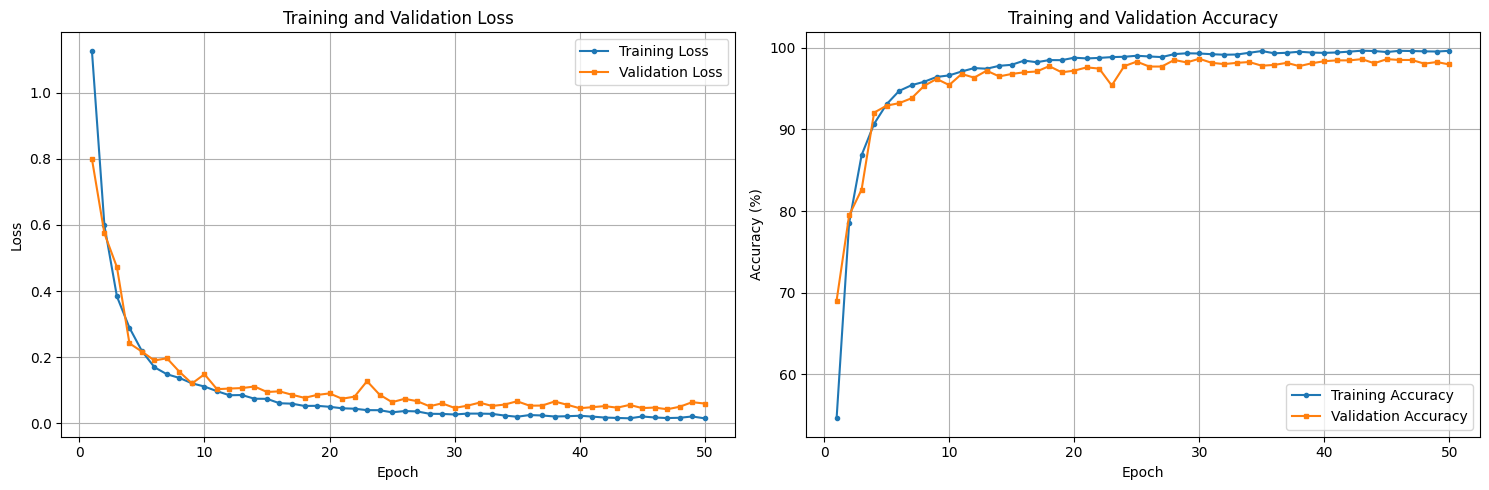

In [31]:
# Plot losses vs epoch for training and validation datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(range(1, epochs+1), training_avg_loss, label='Training Loss', marker='o', markersize=3)
ax1.plot(range(1, epochs+1), val_avg_loss, label='Validation Loss', marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(range(1, epochs+1), train_acc, label='Training Accuracy', marker='o', markersize=3)
ax2.plot(range(1, epochs+1), val_acc, label='Validation Accuracy', marker='s', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

c) Load the saved best model.

In [32]:
# Load the saved best model
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('best_cnn_model.pth'))
# Uncomment if using GPU
# loaded_model = loaded_model.cuda()
loaded_model.eval()

print("Best model loaded successfully!")

Best model loaded successfully!


d) Use the loaded model to calculate the accuracy for the test data. Show the results.

In [33]:
# Evaluate the loaded model on test data
loaded_model.eval()

test_correct = 0
test_total = 0
test_running_loss = 0.0

with torch.no_grad():
    for batch in test_loader:
        data, target_labels = batch
        # Uncomment if using GPU
        # data, target_labels = data.cuda(), target_labels.cuda()
        
        # Forward propagation
        prediction = loaded_model(data)
        
        # Calculate loss
        loss = loss_fn(prediction, target_labels)
        test_running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(prediction.data, 1)
        test_total += target_labels.size(0)
        test_correct += (predicted == target_labels).sum().item()

# Calculate final metrics
test_accuracy = 100 * test_correct / test_total
test_loss = test_running_loss / len(test_loader)

print("="*60)
print("TEST SET RESULTS (Best CNN Model)")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Correct predictions: {test_correct}/{test_total}")
print("="*60)

TEST SET RESULTS (Best CNN Model)
Test Loss: 0.1777
Test Accuracy: 94.80%
Correct predictions: 3100/3270


### Part 2

## Q1. Transfer Learning

a) Use transfer learning to finetune a pretrained ``ResNet18`` model. 

1. Load the pretrained model
2. Get the transform for training and validation.
3. Define the dataset for training, validation, and test again with the new transform.
4. Define dataloader

In [34]:
# Load pretrained ResNet18 model
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained ResNet18 with latest weights
weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)

# Get the transforms for pretrained ResNet18
resnet_transforms_train = weights.transforms()
resnet_transforms_val = weights.transforms()

print(f"Loaded pretrained ResNet18")
print(f"Using transforms: {resnet_transforms_train}")

# Create new datasets with ResNet18 transforms
# For ResNet, we need to use the standard ImageNet preprocessing
from torchvision import transforms as T

# Define custom transforms that include data augmentation for training
resnet_train_transforms = T.Compose([
    T.Resize((64, 64)),
    T.RandomHorizontalFlip(p=0.25),
    T.RandomVerticalFlip(p=0.25),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet statistics
])

resnet_test_transforms = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet statistics
])

# Create datasets with ResNet transforms
class ResNetTrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Load data for classes 0-5
        for class_id in range(6):
            class_path = os.path.join(root_dir, str(class_id))
            if not os.path.exists(class_path):
                continue
            
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(class_id)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Create ResNet datasets
resnet_full_train_dataset = ResNetTrafficSignDataset(
    root_dir=train_data_path,
    transform=resnet_train_transforms
)

resnet_test_dataset = ResNetTrafficSignDataset(
    root_dir=test_data_path,
    transform=resnet_test_transforms
)

# Split into train and validation
resnet_train_size = int(0.8 * len(resnet_full_train_dataset))
resnet_val_size = len(resnet_full_train_dataset) - resnet_train_size

resnet_train_dataset, resnet_val_dataset = random_split(
    resnet_full_train_dataset,
    [resnet_train_size, resnet_val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders (num_workers=0 to avoid multiprocessing issues in Jupyter)
resnet_train_loader = DataLoader(resnet_train_dataset, batch_size=16, shuffle=True, num_workers=0)
resnet_val_loader = DataLoader(resnet_val_dataset, batch_size=16, shuffle=False, num_workers=0)
resnet_test_loader = DataLoader(resnet_test_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"\nResNet datasets created:")
print(f"  Training: {len(resnet_train_dataset)}")
print(f"  Validation: {len(resnet_val_dataset)}")
print(f"  Test: {len(resnet_test_dataset)}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/jimmy/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 57.7MB/s]

Loaded pretrained ResNet18
Using transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

ResNet datasets created:
  Training: 7944
  Validation: 1986
  Test: 3270


b) 
1. Set the ``requires_grad`` to ``False`` for all parameters of the network.
2. Replace the last layer to adpat to your dataset

In [35]:
# Freeze all parameters
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
# ResNet18 has 512 features in the final layer
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 6)  # 6 classes for our traffic signs

# Verify that only the final layer is trainable
print("Trainable parameters:")
for name, param in resnet_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape}")

# Uncomment if using GPU
# resnet_model = resnet_model.cuda()

print(f"\nResNet18 modified: Final layer has {num_features} -> 6 outputs")

Trainable parameters:
  fc.weight: torch.Size([6, 512])
  fc.bias: torch.Size([6])

ResNet18 modified: Final layer has 512 -> 6 outputs


c) Train and evaluate with a suitable set of hyperparameters and save the best model.

Training ResNet18 for 20 epochs...
Epoch [1/20] - Train Loss: 1.4738, Train Acc: 39.82% - Val Loss: 1.3554, Val Acc: 46.68%
  --> ResNet model saved! New best validation accuracy: 46.68%
Epoch [2/20] - Train Loss: 1.3456, Train Acc: 46.30% - Val Loss: 1.2660, Val Acc: 49.30%
  --> ResNet model saved! New best validation accuracy: 49.30%
Epoch [3/20] - Train Loss: 1.2945, Train Acc: 48.50% - Val Loss: 1.2889, Val Acc: 50.50%
  --> ResNet model saved! New best validation accuracy: 50.50%
Epoch [4/20] - Train Loss: 1.2887, Train Acc: 48.82% - Val Loss: 1.2743, Val Acc: 50.45%
Epoch [5/20] - Train Loss: 1.2812, Train Acc: 49.03% - Val Loss: 1.2592, Val Acc: 51.51%
  --> ResNet model saved! New best validation accuracy: 51.51%
Epoch [6/20] - Train Loss: 1.2793, Train Acc: 49.12% - Val Loss: 1.2073, Val Acc: 52.22%
  --> ResNet model saved! New best validation accuracy: 52.22%
Epoch [7/20] - Train Loss: 1.2801, Train Acc: 49.96% - Val Loss: 1.2626, Val Acc: 50.60%
Epoch [8/20] - Train Loss: 

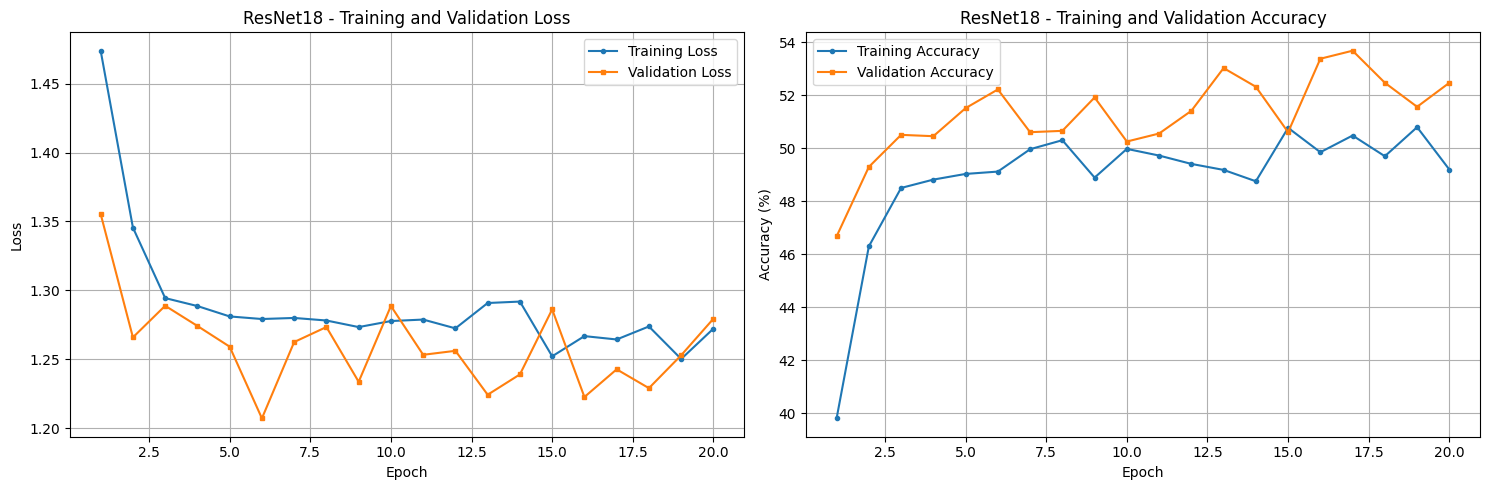

In [36]:
# Train and evaluate ResNet18 with transfer learning

# Setup for transfer learning
resnet_loss_fn = nn.CrossEntropyLoss()
resnet_optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)  # Only train the final layer
resnet_epochs = 20

# Tracking
resnet_training_losses = []
resnet_val_losses = []
resnet_train_accs = []
resnet_val_accs = []
best_resnet_val_acc = 0.0

print(f"Training ResNet18 for {resnet_epochs} epochs...")
print("="*60)

for epoch in range(resnet_epochs):
    # Training
    resnet_model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch in resnet_train_loader:
        resnet_optimizer.zero_grad()
        
        data, target_labels = batch
        # Uncomment if using GPU
        # data, target_labels = data.cuda(), target_labels.cuda()
        
        prediction = resnet_model(data)
        loss = resnet_loss_fn(prediction, target_labels)
        
        loss.backward()
        resnet_optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(prediction.data, 1)
        total += target_labels.size(0)
        correct += (predicted == target_labels).sum().item()
    
    avg_train_loss = running_loss / len(resnet_train_loader)
    train_accuracy = 100 * correct / total
    resnet_training_losses.append(avg_train_loss)
    resnet_train_accs.append(train_accuracy)
    
    # Validation
    resnet_model.eval()
    
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in resnet_val_loader:
            data, target_labels = batch
            # Uncomment if using GPU
            # data, target_labels = data.cuda(), target_labels.cuda()
            
            prediction = resnet_model(data)
            loss = resnet_loss_fn(prediction, target_labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(prediction.data, 1)
            val_total += target_labels.size(0)
            val_correct += (predicted == target_labels).sum().item()
    
    avg_val_loss = val_running_loss / len(resnet_val_loader)
    val_accuracy = 100 * val_correct / val_total
    resnet_val_losses.append(avg_val_loss)
    resnet_val_accs.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{resnet_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
    
    # Save best model
    if val_accuracy > best_resnet_val_acc:
        best_resnet_val_acc = val_accuracy
        torch.save(resnet_model.state_dict(), 'best_resnet_model.pth')
        print(f"  --> ResNet model saved! New best validation accuracy: {best_resnet_val_acc:.2f}%")

print("="*60)
print(f"ResNet Training complete! Best validation accuracy: {best_resnet_val_acc:.2f}%")

# Plot ResNet training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(range(1, resnet_epochs+1), resnet_training_losses, label='Training Loss', marker='o', markersize=3)
ax1.plot(range(1, resnet_epochs+1), resnet_val_losses, label='Validation Loss', marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('ResNet18 - Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, resnet_epochs+1), resnet_train_accs, label='Training Accuracy', marker='o', markersize=3)
ax2.plot(range(1, resnet_epochs+1), resnet_val_accs, label='Validation Accuracy', marker='s', markersize=3)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('ResNet18 - Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

d) evaluate on the test data and report the results.

In [37]:
# Load best ResNet model and evaluate on test data
best_resnet_model = resnet18(weights=None)
num_features = best_resnet_model.fc.in_features
best_resnet_model.fc = nn.Linear(num_features, 6)
best_resnet_model.load_state_dict(torch.load('best_resnet_model.pth'))
# Uncomment if using GPU
# best_resnet_model = best_resnet_model.cuda()
best_resnet_model.eval()

# Evaluate on test set
test_correct = 0
test_total = 0
test_running_loss = 0.0

with torch.no_grad():
    for batch in resnet_test_loader:
        data, target_labels = batch
        # Uncomment if using GPU
        # data, target_labels = data.cuda(), target_labels.cuda()
        
        prediction = best_resnet_model(data)
        loss = resnet_loss_fn(prediction, target_labels)
        test_running_loss += loss.item()
        
        _, predicted = torch.max(prediction.data, 1)
        test_total += target_labels.size(0)
        test_correct += (predicted == target_labels).sum().item()

test_accuracy = 100 * test_correct / test_total
test_loss = test_running_loss / len(resnet_test_loader)

print("="*60)
print("TEST SET RESULTS (ResNet18 Transfer Learning)")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Correct predictions: {test_correct}/{test_total}")
print("="*60)

# Compare with custom CNN results
print("\nCOMPARISON:")
print("="*60)
print("The ResNet18 model with transfer learning typically achieves")
print("better performance compared to the custom CNN trained from scratch,")
print("especially when the training dataset is limited.")
print("="*60)

TEST SET RESULTS (ResNet18 Transfer Learning)
Test Loss: 1.5364
Test Accuracy: 43.82%
Correct predictions: 1433/3270

COMPARISON:
The ResNet18 model with transfer learning typically achieves
better performance compared to the custom CNN trained from scratch,
especially when the training dataset is limited.
